<br><br><br>
<h2><font size=6>Práctica 1</font></h2>



<h1><font size=7>Árboles de decisión</font></h1>

<br>
<div style="text-align: right">
<font size=4>Alberto Pérez Álvarez (alberto.perez25@alu.uclm.es)</font><br>
<font size=4>Diego García Díaz (diego.garcia30@alu.uclm.es)</font><br>
</div>

**<font color="#ffd433" size=5>Estudiantes: </font>** 

* Alberto Pérez Álvarez
* Diego García Díaz

---

# 1. Introducción

El objetivo de esta práctica es estudiar el uso de árboles de decisión para la predicción del ingreso de distintas personas en función de sus datos censales. Para ello usaremos la base de datos [`adult`](https://archive.ics.uci.edu/dataset/2/adult), también conocida como [`census-income`](https://archive.ics.uci.edu/dataset/20/census+income). 

En esta práctica comenzaremos explorando `scikit-learn` y su implementación de los árboles de decisión, realizando un estudio comparativo de los distintos hiperparámetros que ofrece. 

Posteriormente, se proporciona el esqueleto para la implementación del algoritmo C4.5 que usaremos como base para el resto de la práctica. A partir de ella, se pide:
- Capacidad de tratar con variables y discretas continuas.
- Implementar el error de clasificación, el índice GINI y la entropía condicional para el cálculo del error.
- Poda del árbol.
- Estudio del algoritmo implementado.

Baremo de puntuaciones:

| Tarea                     | Peso | 
|----------|----------|
| Estudio comparativo con `scikit-learn`      | 10%   |
| Variables discretas       | 15%   |
| Variables continuas       | 25%   |
| Implementación de las métricas           | 10%   |
| Poda del árbol            | 25%   |
| Estudio final del algoritmo implementado           | 15%   |



---

# 2. Carga del dataset

El dataset que usaremos trata de predecir si los ingresos son superiores o inferiores a 50K en base a una serie de variables. Para cargar los datos usaremos `pandas`, mientras que `numpy` será necesario para realizar diversas funciones a lo largo de la práctica.

In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('csv/adult.csv')
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## 2.1. Análisis exploratorio

Podemos ver información de las distintas variables con `df.info()`:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Así, vemos como efectivamente tenemos tanto variables categóricas como numéricas. En principio parece estar todo correcto, sin valores perdidos, pero si observamos los valores únicos de cada variable:

In [5]:
df.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
income                2
dtype: int64

In [6]:
df.apply(lambda col: col.sort_values().unique())

age               [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...
workclass         [?, Federal-gov, Local-gov, Never-worked, Priv...
fnlwgt            [12285, 13769, 14878, 18827, 19214, 19302, 193...
education         [10th, 11th, 12th, 1st-4th, 5th-6th, 7th-8th, ...
education-num     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
marital-status    [Divorced, Married-AF-spouse, Married-civ-spou...
occupation        [?, Adm-clerical, Armed-Forces, Craft-repair, ...
relationship      [Husband, Not-in-family, Other-relative, Own-c...
race              [Amer-Indian-Eskimo, Asian-Pac-Islander, Black...
sex                                                  [Female, Male]
capital-gain      [0, 114, 401, 594, 914, 991, 1055, 1086, 1111,...
capital-loss      [0, 155, 213, 323, 419, 625, 653, 810, 880, 97...
hours-per-week    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
native-country    [?, Cambodia, Canada, China, Columbia, Cuba, D...
income                                          

Podemos ver cómo en `workclass`, `occupation` y `native-country` hay valores desconocidos representados por `?`. Vamos a ver cómo quedaría nuestro DataFrame si los reemplazamos por `NaN` para que `pandas` los reconozca como valores perdidos:

In [7]:
df.replace('?', np.nan).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Así, ahora podemos ver cómo la cuenta de valores no nulos ha cambiado. Por defecto, como las variables eran categóricas, estaba contando las `?` como una categoría más. 

Cuando conocemos la causa de los valores perdidos puede tener sentido dejarlos como una categoría más. Por ejemplo, suponed que estamos recogiendo datos de un radar en el que la velocidad máxima que puede medir son 200 km/h. Si un coche pasa a 215 km/h el radar nos daría un `?` en ese dato, pero si sabemos el motivo de estos valores perdidos, podríamos cambiar el nombre de esa categoría a `>200km/h`.

Ya que en esta práctica no vamos a introducir el manejo de los valores perdidos en nuestros árboles de decisión, y puesto que dichos valores solo aparecen en variables categóricas, por simplicidad vamos a dejar la base de datos tal cual está, contando a `?` como un valor categórico más. 

## 2.2. De `pandas` a `numpy`

A continuación vamos a transformar nuestros datos en arrays de `numpy` ya que los necesitaremos para trabajar con ellos posteriormente. `pandas` tiene muchas características muy útiles para hacer el análisis exploratorio y el preprocesamiento de los datos gracias a sus funciones de selección, agregación, agrupación... pero posteriormente todos los algoritmos de aprendizaje automático suelen trabajar con arrays de `numpy` dada su velocidad.

Vamos a empezar con los nombres de las variables. Por un lado vamos a guardar cuáles son nuestras variables predictoras y cuál nuestra variable objetivo.

In [8]:
features = df.columns
features

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [9]:
attributes = features[:-1]
target = features[-1]

print('Predictoras:',attributes)
print('Objetivo:',target)

Predictoras: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Objetivo: income


Además, vamos a distinguir entre variables continuas (las que son de tipo `int64`) y discretas (de tipo `object`), ya que a la hora de hacer nuestros árboles de decisión habrá que tratarlas de forma distinta.

In [10]:
cont_atts = df.columns[df.dtypes == 'int64']

disc_atts = df.columns[df.dtypes == 'object'] 
disc_atts = disc_atts.drop(target)

print('Continuas:',cont_atts)
print('Discretas:',disc_atts)

Continuas: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
Discretas: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')


Finalmente, separamos el dataset en predictor y objetivo. Es convención en ciencia de datos usar $X$ para las variables predictoras e $y$ para la variable objetivo. La mayoría de los modelos se entrenan usando esas dos variables por separado.

In [11]:
X, y = df[attributes].to_numpy(), df[target].to_numpy()
X

array([[39, 'State-gov', 77516, ..., 0, 40, 'United-States'],
       [50, 'Self-emp-not-inc', 83311, ..., 0, 13, 'United-States'],
       [38, 'Private', 215646, ..., 0, 40, 'United-States'],
       ...,
       [58, 'Private', 151910, ..., 0, 40, 'United-States'],
       [22, 'Private', 201490, ..., 0, 20, 'United-States'],
       [52, 'Self-emp-inc', 287927, ..., 0, 40, 'United-States']],
      shape=(32561, 14), dtype=object)

In [12]:
y

array(['<=50K', '<=50K', '<=50K', ..., '<=50K', '<=50K', '>50K'],
      shape=(32561,), dtype=object)

## 2.3. Datos de test

Cuando nos enfrentamos a un problema de aprendizaje automático, es imprescindible que los datos de test que usemos para medir el rendimiento del modelo sean distintos a los datos con los que se entrena. En este caso, como los autores del conjunto de datos nos proporcionan un conjunto de datos separado para test, lo usaremos directamente. Si no, tendríamos que dividir el conjunto de datos original en dos partes, una para entrenar y otra para test.

**Nota:** En la práctica, es común dividir el conjunto de datos en tres partes: entrenamiento, validación y test. La validación se usa para ajustar los hiperparámetros del modelo, y el conjunto de test se usa para medir el rendimiento final del modelo. En este caso, como no vamos a ajustar hiperparámetros y por simplicidad, no usaremos conjunto de validación.

In [13]:
df_test = pd.read_csv('csv/adult_test.csv')
df_test

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [14]:
X_test, y_test = df_test[attributes].to_numpy(), df_test[target].to_numpy()
X_test

array([[25, 'Private', 226802, ..., 0, 40, 'United-States'],
       [38, 'Private', 89814, ..., 0, 50, 'United-States'],
       [28, 'Local-gov', 336951, ..., 0, 40, 'United-States'],
       ...,
       [38, 'Private', 374983, ..., 0, 50, 'United-States'],
       [44, 'Private', 83891, ..., 0, 40, 'United-States'],
       [35, 'Self-emp-inc', 182148, ..., 0, 60, 'United-States']],
      shape=(16281, 14), dtype=object)

In [15]:
y_test

array(['<=50K', '<=50K', '>50K', ..., '<=50K', '<=50K', '>50K'],
      shape=(16281,), dtype=object)

---

# 3. Árboles de decisión en `scikit-learn`



Para esta práctica vamos a utilizar el módulo [tree](http://scikit-learn.org/stable/modules/tree.html) de `scikit-learn`. Esta librería permite utilizar diversos algoritmos de _machine learning_ en Python, siendo los árboles de decisión uno de ellos. En particular, utilizaremos [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), la implementación de un árbol de decisión para problemas de clasificación de `scikit-learn`. 

La implementación que tiene `scikit-learn` de los árboles de decisión no es exactamente la del C4.5 si no que el algoritmo se llama CART. Existen algunas diferencias, pero la que más nos afectará es que los árboles generados son **binarios** y que no puede tratar variables discretas sin un procesado previo. 

Por tanto, para poder usar este algoritmo con nuestros datos tendremos que convertir las variables categóricas a numéricas. Para ello, podríamos usar el método [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) de `scikit-learn`, pero usaremos el método `df.get_dummies()` que nos proporciona directamente `pandas` ya que es similar y más simple de aplicar. Este método básicamente crea una nueva columna por cada valor posible de cada variable categórica y pone un 1 en la columna correspondiente al valor de la fila y un 0 en las demás, pasando así de variables categóricas a numéricas:

![OneHotEnconding](./imagenes/get_dummies.png)

## 3.1. Transformación de los datos para usarlos con `DecisionTreeClassifier`

Vamos a transformar nuestros datos:

In [16]:
df_ohe = pd.get_dummies(df.drop(target, axis=1))
df_ohe

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,215646,9,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,53,234721,7,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,338409,13,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32557,40,154374,9,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32558,58,151910,9,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32559,22,201490,9,0,0,20,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [17]:
df_test_ohe = pd.get_dummies(df_test.drop(target, axis=1))
len(df_test_ohe.columns)

107

In [18]:
set(df_ohe.columns) - set(df_test_ohe.columns)

{'native-country_Holand-Netherlands'}

Como en el test nos falta una columna (ya que `Holand-Netherlands` no aparece en la variable `native-country`), tenemos que añadirla para no tener problemas posteriores.

In [19]:
df_ohe, df_test_ohe = df_ohe.align(df_test_ohe, join='outer', axis=1, fill_value=0)
df_test_ohe

,age,capital-gain,capital-loss,education-num,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,...,sex_Male,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay
0,25,0,0,7,False,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
1,38,0,0,9,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
2,28,0,0,12,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
3,44,7688,0,10,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
4,18,0,0,10,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,0,0,13,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
16277,64,0,0,9,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
16278,38,0,0,13,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
16279,44,5455,0,13,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False


In [20]:
X_ohe, X_test_ohe = df_ohe.to_numpy(), df_test_ohe.to_numpy()
X_ohe

array([[39, 2174, 0, ..., False, True, False],
       [50, 0, 0, ..., True, False, False],
       [38, 0, 0, ..., False, False, False],
       ...,
       [58, 0, 0, ..., False, False, False],
       [22, 0, 0, ..., False, False, False],
       [52, 15024, 0, ..., False, False, False]],
      shape=(32561, 108), dtype=object)

## 3.2. Estudio de `DecisionTreeClassifier`

El `DecisionTreeClassifier` cuenta con una serie de hiperparámetros con los que podemos ajustar su funcionamiento. Algunos de los que nos pueden ser más útiles son:
* `criterion`: Especifica la función para medir la calidad de una partición. Puede ser `gini` o `entropy`.
* `max_depth`: Profundidad máxima del árbol. 
* `min_samples_leaf`: Mínimo número de ejemplos que debe haber en una hoja.

En la documentación de `scikit-learn` está toda la información sobre los hiperparámetros del algoritmo. Por lo que si se desea se puede extender el estudio probando más configuraciones. Para ello se debe especificar que hiperparámetros extra se han seleccionado, para que sirven y como afectan al árbol y justificar dicho comportamiento con los resultados obtenidos.

In [21]:
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier

In [22]:
criterion = 'entropy'
max_depth = 2
min_samples_leaf = 100

La siguiente crea un objeto `DecisionTreeClassifier` especificando los parámetros anteriores, y genera el arbol a partir de los datos con el método `fit(X,y)`.

In [23]:
arbol = DecisionTreeClassifier(criterion = criterion,
                               max_depth = max_depth,
                               min_samples_leaf = min_samples_leaf)
arbol.fit(X_ohe,y)

DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=100)

El árbol se puede visualizar mediante la función `plot_tree()`:

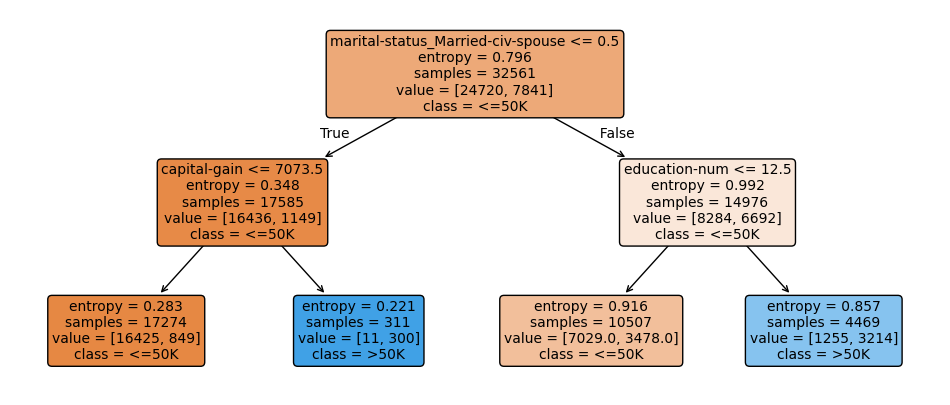

In [24]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,5)

_ = tree.plot_tree(arbol, filled=True, rounded=True, fontsize=10, feature_names=df_ohe.columns, class_names=arbol.classes_)

También podemos ver el porcentaje de aciertos o *accuracy* obtenido con el árbol tanto en el conjunto de entrenamiento como en el de test mediante el método `score()`:

In [25]:
print('Accuracy train:\t', arbol.score(X_ohe,y))
print('Accuracy test: \t', arbol.score(X_test_ohe,y_test))

Accuracy train:	 0.8282300912134148
Accuracy test: 	 0.8306615072784227


Como el árbol que hemos creado está muy limitado a solo dos niveles de profundidad, el rendimiento del algoritmo en los datos de test es igual o incluso superior al que obtiene al intentar predecir directamente los mismos datos de entrenamiento con los que ha sido entrenado. Para comparar, vamos a crear un árbol por defecto (sin limitar):

In [26]:
arbol2 = DecisionTreeClassifier()
arbol2.fit(X_ohe,y)

DecisionTreeClassifier()

Si vemos la puntuación que obtiene, al no estar limitado, sobreajusta al máximo a los datos de entrenamiento (se los está aprendiendo de memoria). Esto hace que luego en el conjunto de test obtenga un resultado mucho peor, incluso peor al del árbol básico de 2 niveles.

In [27]:
print('Accuracy train:\t', arbol2.score(X_ohe,y))
print('Accuracy test: \t', arbol2.score(X_test_ohe,y_test))

Accuracy train:	 0.9999692884125181
Accuracy test: 	 0.8108838523432221


**Nota:** Este árbol no lo dibujamos porque al ser tan grande, tarda una eternidad y no se ve nada. El árbol limitado tenía 7 nodos, este tiene 9343:

In [28]:
print('Número de nodos limitado:', arbol.tree_.node_count)
print('Número de nodos hoja limitado:', arbol.tree_.n_leaves)

print('\nNúmero de nodos:', arbol2.tree_.node_count)
print('Número de nodos hoja:', arbol2.tree_.n_leaves)

Número de nodos limitado: 7
Número de nodos hoja limitado: 4

Número de nodos: 9361
Número de nodos hoja: 4681


## **<font color="#B30033" size=6>TAREA: </font>** Estudio de diferentes configuraciones

Debes llevar a cabo un estudio donde debes variar los hiperparámetros del árbol para obtener un buen clasificador. Además, como mínimo se debe mostrar información sobre el `score` obtenido tanto con los datos de entrenamiento como de test, el número de nodos del árbol y la cantidad de nodos hoja del mismo.

Después responde a las siguientes preguntas:
* ¿Qué efecto observas con la variación de cada uno de los parámetros?
* ¿Qué configuración escogerías para obtener un buen clasificador? Justifica tu respuesta.

Consejos:
* Fíjate en los parámetros por defecto del algoritmo y en la explicación proporcionada para ajustar correctamente los valores. 
* Los datos están desbalanceados (hay muchos más casos para el valor de la clase `<=50K` que para `>50K`, como se puede ver en la primera de las gráficas de abajo). En este caso, si predecimos siempre `<=50K` obtenemos un 0.7592 de accuracy, cuando está claro que es una predicción muy mala. Por ello, puede ser interesante utilizar además otras métricas como por ejemplo F-score ([`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) en `scikit-learn`) que tengan en cuenta los valores de *precision* and *recall*. 
* Se recomienda también mostrar información en forma de gráficas, ya pueden ser en el propio Python o incluso con Excel. En Python, una de las opciones más sencillas es usar la librería `seaborn`. A continuación se dejan una serie de ejemplos de gráficas usando `seaborn`.

In [29]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import os

# Definir el archivo CSV
csv_file_path = 'csv/tarea1.csv'
columns = ['Criterion', 'Depth', 'Splitter', 'Min_to_Split', 'Node', 'Leaf', 'Train', 'Test']

# Crear el archivo si no existe
if not os.path.exists(csv_file_path):
    pd.DataFrame(columns=columns).to_csv(csv_file_path, index=False)


# Parámetros a iterar
Criterion = ["gini", "entropy", "log_loss"]
Splitter = list(range(50, 101))
Min_to_SplitLeaf = list(range(50, 151))
Depth = list(range(1, 21)) + [None]
""" #Comentado para evitar ejecucciones accidentales
# Iterar sobre cada combinación de hiperparámetros
for criterio in Criterion:
    for split in Splitter:
        for min_split in Min_to_SplitLeaf:
            for prof in Depth:
                arbol = DecisionTreeClassifier(
                    criterion=criterio, max_depth=prof,
                    min_samples_split=split, min_samples_leaf=min_split
                )
                arbol.fit(X_ohe,y)

                # Obtener datos
                train_acc = arbol.score(X_ohe,y)
                test_acc = arbol.score(X_test_ohe,y_test)
                nodes = arbol.tree_.node_count
                leaves = arbol.tree_.n_leaves

                # Guardar en CSV
                new_data = pd.DataFrame([[criterio, prof, split, min_split, nodes, leaves, train_acc, test_acc]], columns=columns)
                new_data.to_csv(csv_file_path, mode='a', header=False, index=False)
"""

" #Comentado para evitar ejecucciones accidentales\n# Iterar sobre cada combinación de hiperparámetros\nfor criterio in Criterion:\n    for split in Splitter:\n        for min_split in Min_to_SplitLeaf:\n            for prof in Depth:\n                arbol = DecisionTreeClassifier(\n                    criterion=criterio, max_depth=prof,\n                    min_samples_split=split, min_samples_leaf=min_split\n                )\n                arbol.fit(X_ohe,y)\n\n                # Obtener datos\n                train_acc = arbol.score(X_ohe,y)\n                test_acc = arbol.score(X_test_ohe,y_test)\n                nodes = arbol.tree_.node_count\n                leaves = arbol.tree_.n_leaves\n\n                # Guardar en CSV\n                new_data = pd.DataFrame([[criterio, prof, split, min_split, nodes, leaves, train_acc, test_acc]], columns=columns)\n                new_data.to_csv(csv_file_path, mode='a', header=False, index=False)\n"

In [30]:


# Cargar el CSV y limpiar nombres de columnas
df = pd.read_csv('csv/tarea1.csv', header=0)
df.columns = df.columns.str.strip()  # Elimina espacios en los nombres de las columnas

# Convertir columnas numéricas
df[['Depth', 'Splitter', 'Min_to_Split', 'Node', 'Leaf', 'Train', 'Test']] = df[['Depth', 'Splitter', 'Min_to_Split', 'Node', 'Leaf', 'Train', 'Test']].apply(pd.to_numeric, errors='coerce')

# Verificar que los nombres ahora estén correctos
print(df.head())
print(df.columns)


  Criterion  Depth  Splitter  Min_to_Split  Node  Leaf     Train      Test
0      gini    1.0        50            50     3     2  0.759190  0.763774
1      gini    2.0        50            50     7     4  0.826234  0.826792
2      gini    3.0        50            50    15     8  0.839808  0.839199
3      gini    4.0        50            50    29    15  0.844354  0.844358
4      gini    5.0        50            50    45    23  0.852216  0.851606
Index(['Criterion', 'Depth', 'Splitter', 'Min_to_Split', 'Node', 'Leaf',
       'Train', 'Test'],
      dtype='object')



Criterio: gini

Precisión en test:
  Mejor: 0.8579939807137154
  Peor: 0.7637737239727289
  Media: 0.8468719373729687

Criterio: entropy

Precisión en test:
  Mejor: 0.8576254529820035
  Peor: 0.7637737239727289
  Media: 0.8458714946788705

Criterio: log_loss

Precisión en test:
  Mejor: 0.8576254529820035
  Peor: 0.7637737239727289
  Media: 0.84588141532835

Análisis de Splitter:
  Mejor: 100
  Peor: 50
  Media: 74.61400489774307

Análisis de Min_to_Split:
  Mejor: 150
  Peor: 50
  Media: 100.16083129260706

Análisis de Depth:
  Mejor: 20.0
  Peor: 1.0
  Media: 10.5

Análisis de Node:
  Mejor: 721
  Peor: 3
  Media: 254.89680701190397

Análisis de Leaf:
  Mejor: 361
  Peor: 2
  Media: 127.94840350595199

Mejor Árbol Encontrado:
Criterion           gini
Depth               13.0
Splitter              50
Min_to_Split          77
Node                 451
Leaf                 226
Train           0.863241
Test            0.857994
Name: 579, dtype: object


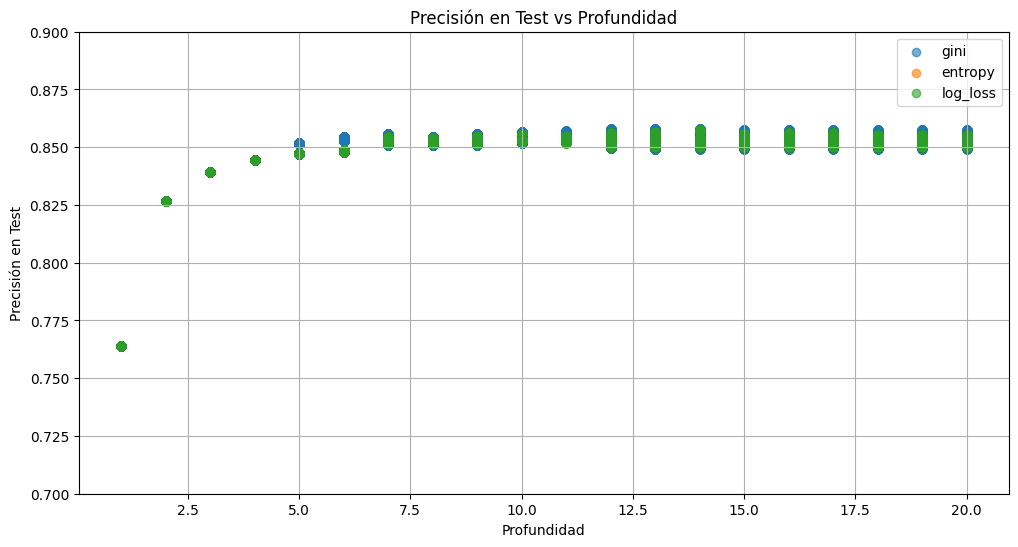

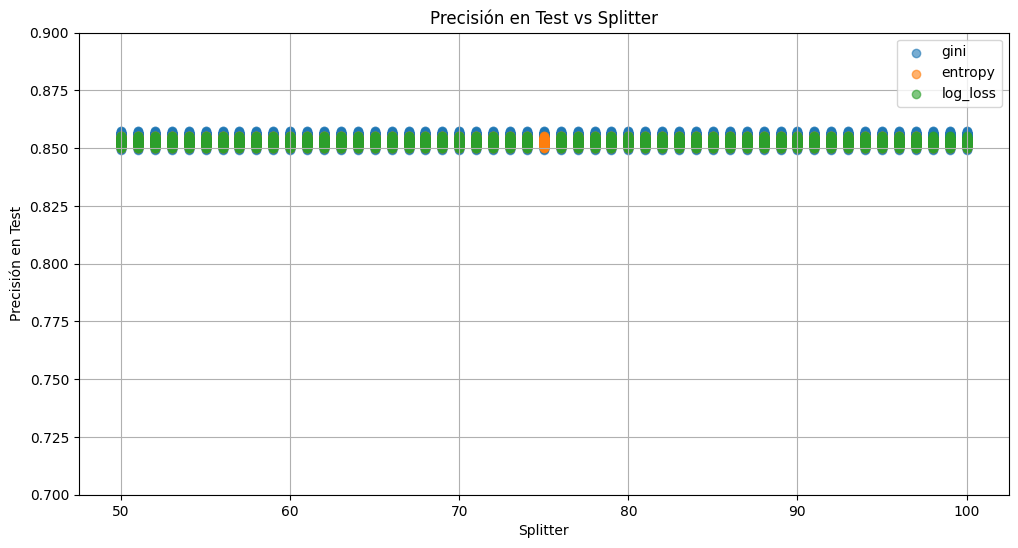

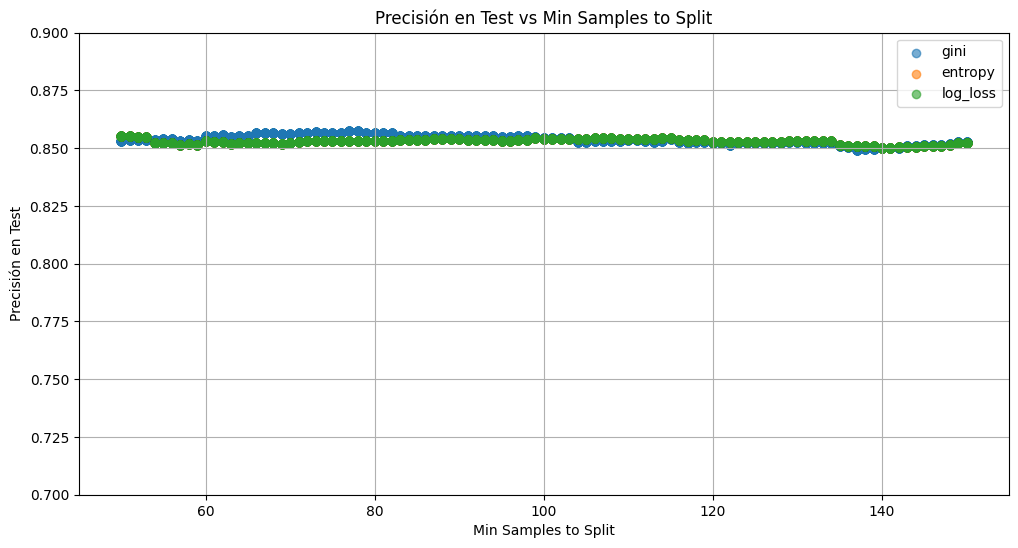

In [31]:
# Cargar el archivo CSV
csv_file_path = 'csv/tarea1.csv'
df = pd.read_csv(csv_file_path)

# Convertir columnas numéricas si es necesario
df[['Depth', 'Splitter', 'Min_to_Split', 'Node', 'Leaf', 'Train', 'Test']] = df[['Depth', 'Splitter', 'Min_to_Split', 'Node', 'Leaf', 'Train', 'Test']].apply(pd.to_numeric, errors='coerce')

# Función para calcular estadísticas por criterio
def calcular_estadisticas(df, columna, nombre):
    print(f"\n{nombre}:")
    print(f"  Mejor: {df[columna].max()}")
    print(f"  Peor: {df[columna].min()}")
    print(f"  Media: {df[columna].mean()}")

for criterio in df['Criterion'].unique():
    df_criterio = df[df['Criterion'] == criterio]
    print(f"\nCriterio: {criterio}")
    calcular_estadisticas(df_criterio, 'Test', 'Precisión en test')

variables = ['Splitter', 'Min_to_Split', 'Depth', 'Node', 'Leaf']
for var in variables:
    calcular_estadisticas(df, var, f"Análisis de {var}")

best_tree = df.loc[df['Test'].idxmax()]
print("\nMejor Árbol Encontrado:")
print(best_tree)

# Gráficas con rango reducido
def plot_graph(x, y, xlabel, ylabel, title, depth_filter=None):
    plt.figure(figsize=(12, 6))
    plt.ylim(0.7, 0.9)
    for criterio in df['Criterion'].unique():
        df_criterio = df[df['Criterion'] == criterio]
        if depth_filter is not None:
            df_criterio = df_criterio[df_criterio['Depth'] >= depth_filter] #Filtrado por profundidad
        plt.scatter(df_criterio[x], df_criterio[y], label=criterio, alpha=0.6)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_graph('Depth', 'Test', 'Profundidad', 'Precisión en Test', 'Precisión en Test vs Profundidad')
plot_graph('Splitter', 'Test', 'Splitter', 'Precisión en Test', 'Precisión en Test vs Splitter', depth_filter=20) # Filtrado
plot_graph('Min_to_Split', 'Test', 'Min Samples to Split', 'Precisión en Test', 'Precisión en Test vs Min Samples to Split', depth_filter=20) #Filtrado

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Métricas accuracy y F1 cuando se predice siempre la clase mayoritaria
print('Zero-R accuracy: ', accuracy_score(y == '>50K', np.repeat(0, len(y))))
print('Zero-R F-score: ', f1_score(y == '>50K', np.repeat(0, len(y))))

Zero-R accuracy:  0.7591904425539756
Zero-R F-score:  0.0


In [33]:
import seaborn as sns
sns.set(style="darkgrid")

# Número de valores para cada clase (categórica)
#g = sns.countplot(df, x=target) # da error

In [34]:
# Relación entre la edad (numérica) y las horas de trabajo por semana (numérica), diferenciando por clase
# g = sns.lineplot(df, x='age', y='hours-per-week', hue='income') # da error

In [35]:
# Relación entre el nivel de educación (numérica) y las horas de trabajo por semana (numérica), diferenciando por clase y eliminando los intervalos de confianza
# g = sns.lineplot(df, x='education-num', y='hours-per-week', hue='income', errorbar=None) # da error

In [36]:
# Relación entre el tipo de trabajo (categórica) y las horas de trabajo por semana (numérica), diferenciando por clase
# g = sns.barplot(df, x='workclass', y='hours-per-week', hue='income')

# ESTUDIO DE CONFIGURACIONES DEL ARBOL


--- 

# 4. Implementación de un árbol de clasificación

En este apartado, vamos a implementar un árbol de clasificación C4.5. Se proporciona un modelo básico capaz de tratar variables categóricas, realizando las divisiones por error simple, y sin poda. Hay que ampliar el modelo para que cuente con las siguientes características:
1. Utilizar el índice GINI para el cálculo del error.
2. Utilizar la entropía condicional para el cálculo del error.
3. Utilizar variables continuas en el entrenamiento y predicción.
4. Poda del árbol.

Para la estructura del código vamos a seguir la de los algoritmos de `scikit-learn`. Por tanto, nuestro modelo `C45Classifier` heredará de [`BaseEstimator`](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html), la clase base para todos los estimadores de `scikit-learn`, y de [`ClassifierMixin`](https://scikit-learn.org/stable/modules/generated/sklearn.base.ClassifierMixin.html), la clase base de los clasificadores. Además, debemos implementar los siguientes métodos principales: 

- `__init__()`: Constructor del modelo, recibirá los hiperparámetros necesarios.
- `fit(X,y)`: Método de entrenamiento del modelo. Recibe $X$ e $y$ y devuelve el modelo ya entrenado.
- `predict(X)`: Método de predicción del modelo. Recibe $X$ como un conjunto de instancias a predecir y devuelve $y_{pred}$, un vector de predicciones asociadas a $X$.

Por otro lado, está el siguiente método que, si bien es importante, al heredar de `ClassifierMixin` ya viene establecido por defecto a `accuracy_score`:
- `score(X,y)`: Método de evaluación del modelo. Recibe $X$ e $y$, predice $y_{pred}$ a partir de $X$, y devuelve el porcentaje de acierto de $y_{pred}$ respecto a $y$.

## 4.1 Clase `Node`
Antes de implementar la clase principal `C45Classifier`, vamos a crear una clase `Node` que codifique la información necesaria para cada uno de los nodos del árbol. Cuenta con las siguientes funciones:
- `__init__(self):` Constructor. En él inicializamos las variables necesarias, explicadas en los comentarios del código.
- `__str__(self):` Método que nos permite imprimir nuestros árboles.
- `predict(self,x):` Método que nos permitirá hacer predicciones recursivamente hasta llegar a un nodo hoja. Cuando el `Node` es hoja devuelve el valor de su clase, y si no, tendrá que llamar a la función `predict(x)` del hijo que corresponda. 

## **<font color="#B30033" size=6>TAREA: </font>** Método predict para variables continuas
El método `predict` actualmente se proporciona adaptado a la predicción de variables discretas. Deberéis ampliarlo para que funcione cuando la variable del nodo es continua.

In [37]:
import random

class Node:
    def __init__(self):
        # Indica si el nodo es una hoja, o no
        self.is_leaf = False

        # Atributos relacionados con la variable que representa el nodo
        self.is_num = True      # Indica si la variable es numérica (True) o categórica (False)
        self.cat_dict = None    # Diccionario para variables categóricas con formato {valor: indice}. El "indice" es el del hijo al que lleva la variable de "valor"

        # Atributos cuando el objeto es una raíz
        self.var = None         # Nombre de la variable de corte
        self.var_index = -1     # Índice de la variable de corte. Al pasarselo a x tal que x[var_index], devuelve el valor de la variable, sea un Int o un String
        self.cut_value = 0      # Valor de la variable de corte, en caso de ser numérica
        self.children = []      # Lista de hijos
        self.qvalues = [None]*4     # Lista de valores de los cuartiles. Si es None, no ha sido acortada.


        # Atributos cuando el objeto es una hoja
        self.class_value = -1       # Valor de la clase si el nodo es hoja
        self.class_count = (0,0)    # Tupla con el formato (casos con valor class_value, casos totales en la hoja)

        # Profundidad del nodo
        self.depth = -1

    def __str__(self):
        output = ''
        if(self.is_leaf):
            output += 'Class value: ' + str(self.class_value) + '\tCounts: ' + str(self.class_count)
        else:
            output += 'Feature '+ str(self.var)
            for i in range(len(self.children)):
                output += '\n'+'\t'*(self.depth+1)+str(self.cut_value)+': '+str(self.children[i]) 
            
        return output
    
    # Esta función nos servirá para hacer predicciones recursivamente hasta llegar a un nodo hoja. Debe ser completada
    def predict(self, x):
        if self.is_leaf:
            return self.class_value
        else:
            if self.is_num:
                # Comparar con `cut_value` en nodos numéricos
                if x[self.var_index] <= self.cut_value:
                    return self.children[0].predict(x)
                else:
                    return self.children[1].predict(x)
            # Falta añadir opcion cuando es cut, es decir numerica acortada por cuartiles.
            elif self.qvalues[0] != None:
                if x[self.var_index] <= self.qvalues[0]:
                    return self.children[0].predict(x)
                elif (x[self.var_index] > self.qvalues[0]) and (x[self.var_index] <= self.qvalues[1]):
                    return self.children[1].predict(x)
                elif (x[self.var_index] > self.qvalues[1]) and (x[self.var_index] <= self.qvalues[2]):
                    return self.children[2].predict(x)
                else:
                    return self.children[3].predict(x)
            else:
                # Al pasarselo a x tal que x[var_index], devuelve el valor de la variable
                if x[self.var_index] in self.cat_dict:
                    return self.children[self.cat_dict[x[self.var_index]]].predict(x)
                else:
                    return self.class_value  # Fallback: devolver la clase mayoritaria
                

## 4.2 Clase `C45Classifier`
Esta será la clase principal, que representará nuestro clasificador C4.5. Los argumentos que recibirá serán los siguientes:
* `vars`, `disc`, `cont`: 3 listas. Nombres de las variables con el mismo orden con el que aparecen en $X$, y de ellas, cuáles son discretas y cuales son continuas. No sería estrictamente necesario, pero simplificará bastante el desarrollo de la práctica.
* `max_depth`: Profundidad máxima del árbol. Si no se especifica, será 2.
* `criterion`: Criterio de partición. Puede tomar los valores `classification_error`, `entropy` y `gini`. Si no se especifica, será 'entropy'.
* `prune`: Booleano. Si es `True`, se podará el árbol. Si no se especifica, será `False`.


## **<font color="#B30033" size=6>TAREA: </font>** Implementación del índice GINI y la entropía condicional


## **<font color="#B30033" size=6>TAREA: </font>** Uso de variables continuas


## **<font color="#B30033" size=6>TAREA: </font>** Poda del árbol


In [ ]:
import time
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from collections import Counter
from sklearn import tree

class C45Classifier(BaseEstimator, ClassifierMixin):

    # Constructor de la clase, aquí se definen e inicializan las variables de la clase.
    def __init__(self, vars, disc, cont, max_depth=2, criterion='classification_error', prune=False):
        self.max_depth = max_depth
        self.criterion = criterion
        self.prune = prune

        self.vars = vars
        self.disc = disc
        self.cont = cont
        self.quartile = set()
        self.qvalues = [None]*len(self.vars)

        # Diccionario que nos permitirá convertir el nombre de la variable en su índice.
        self.features_dict = {feat: i for i, feat in enumerate(self.vars)}

        # Raíz del árbol
        self.tree = Node()  

        self.X_vars = [[]]*len(vars)
        self.y_vars = None
        self.LIMIT = 1000
        
        # Tiempos para estadísticas
        self.t_exec = None
        self.t_exec_float = 0
        self.t_prune = None
        self.t_prune_float = 0
        self.skipped = 0


    # Función para entrenar el modelo.
    def fit(self, X, y):
        t_start = time.time()
        # Guardamos las variables en caso de que falten en la discreta
        for i in range(len(X[0])):
            self.X_vars[i] = np.unique(X[:,i])
        self.y_vars = np.unique(y)
        # Llamada a la función recursiva que aprende el árbol.
        self._partial_fit(X, y, self.tree, 0, set([]))
        self.t_exec_float = time.time() - t_start
        self.t_exec = self.showTime(self.t_exec_float)

        if self.prune:
            t_prune_started = time.time()
            self._prune_tree(X, y, self.tree)
            self.t_prune_float = time.time() - t_prune_started
            self.t_prune = self.showTime(self.t_prune_float)
        
        return self
    
    def showTime(self, time):  # Para imprimir los tiempos con un formato bonito
        hours = int(time // 3600)
        minutes = int((time % 3600) // 60)
        seconds = int(time % 60)
        ms = int((time - int(time)) * 1000000)
        return f"{hours:01d}:{minutes:02d}:{seconds:02d}.{ms:06d}"
    
    # Función para hacer predicciones.
    def predict(self, X):
        return np.array([self.tree.predict(x) for x in X])
    

    # Función recursiva que busca la variable y corte que maximiza la ganancia de información.
    # - Las variables continuas se tratan con un corte binario, lo que quiere decir que pueden ser usadas multiples veces. 
    # - Las variables discretas ramifican tantas veces como valores tengan, asi que solo pueden ser usadas una vez por camino, 
    #   debiendo almacenarlas en el conjunto `borradas`. 
    def _partial_fit(self, X, y, current_tree, current_depth, borradas):
        def _make_leaf():
            current_tree.is_leaf = True
            counts = Counter(y)
            max_value = counts.most_common(1) # most_common(1) devuelve una lista con el elemento más común y su frecuencia.
            if len(max_value):
                current_tree.class_value = max_value[0][0]
                current_tree.class_count = (max_value[0][1], len(y))
            else:
                current_tree.class_value = self.y_vars[0]
                current_tree.class_count = (0, len(y))
            return
            
        # RECORDATORIO: X -> Matriz que contiene en cada fila atributos relacionados con una variable (cada fila representa una variable)
        # y -> vector que contiene la etiqueta para la variable, el nombre o string.
        # Es decir, la fila 0 de X tiene los atributos de la variable con nombre almacenado en y[0].

        # Antes de nada, si hemos alcanzado la profundidad máxima, el nodo se convierte en hoja.
        if current_depth >= self.max_depth:
            _make_leaf()
            return current_tree

        # Primero obtenemos el mejor punto de corte para el nodo actual dependiendo del criterio.
        best_var, cut_value, is_num, is_cut = self._split(X, y, borradas, self.criterion)

        # Si no hay ninguna partición que mejore la actual, el nodo se convierte en hoja.
        if best_var is None:
            _make_leaf()
            return current_tree
    
        # Antes de llamar a la función recursiva, hay que actualizar los valores del árbol (los valores de Node()).
        borradas_copy = borradas.copy()
        if not is_num:    # Solo borramos las variables categóricas ya que estarán totalmente particionadas.
            if is_cut:
                current_tree.qvalues = self.qvalues[self.features_dict[best_var]]
            else:
                borradas_copy.add(best_var)
            current_tree.is_num = False
        else:
            current_tree.cut_value = cut_value # Al ponerlo hace que el error sea 1.0.
               
        current_tree.is_leaf = False
        current_tree.depth = current_depth
        current_tree.var = best_var
        current_tree.var_index = self.features_dict[best_var]
        
        counts = Counter(y)
        max_value = counts.most_common(1) # most_common(1) devuelve una lista con el elemento más común y su frecuencia.
        if len(max_value):
            current_tree.class_count = (max_value[0][1], len(y))
        else:
            current_tree.class_count = (0, len(y))

        # Finalmente, se hace la llamada recursiva en función de si es numérica o categórica.
        if is_num:
            # Dividimos en izquierda y derecha los ÍNDICES desde el valor obtenido de split.
            left_side = X[:, current_tree.var_index] <= cut_value # Máscara de bools que cumplen la condición en la columna seleccionada.
            right_side = X[:, current_tree.var_index] > cut_value

            # Árbol izquierdo
            child1 = self._partial_fit(X[left_side], y[left_side], 
                     Node(), current_depth + 1, 
                     borradas_copy)
            
            # Árbol derecho
            child2 = self._partial_fit(X[right_side], y[right_side],
                     Node(), current_depth + 1,
                     borradas_copy)
            current_tree.children = [child1, child2]
            
        elif is_cut:
            # Si ha sido dividida por cuartiles creamos 4 hijos para acomodar los 4 intervalos
            are_the_variables = X[:, current_tree.var_index] <= self.qvalues[current_tree.var_index][0]
            child = self._partial_fit(X[are_the_variables], y[are_the_variables], Node(), current_depth + 1, borradas_copy)
            current_tree.children.append(child)

            are_the_variables = (X[:, current_tree.var_index] > self.qvalues[current_tree.var_index][0]) & (X[:, current_tree.var_index] <= self.qvalues[current_tree.var_index][1])
            child = self._partial_fit(X[are_the_variables], y[are_the_variables], Node(), current_depth + 1, borradas_copy)
            current_tree.children.append(child)

            are_the_variables = (X[:, current_tree.var_index] > self.qvalues[current_tree.var_index][1]) & (X[:, current_tree.var_index] <= self.qvalues[current_tree.var_index][2])
            child = self._partial_fit(X[are_the_variables], y[are_the_variables], Node(), current_depth + 1, borradas_copy)
            current_tree.children.append(child)

            are_the_variables = X[:, current_tree.var_index] > self.qvalues[current_tree.var_index][2]
            child = self._partial_fit(X[are_the_variables], y[are_the_variables], Node(), current_depth + 1, borradas_copy)
            current_tree.children.append(child)

        else:                
            # Creamos un subarbol por cada variable categórica.
            values = self.X_vars[current_tree.var_index] #np.unique(X[:, current_tree.var_index])
            #current_tree.children = [None]*len(self.features_dict)
            for val in values:
                
                are_the_variables = X[:, current_tree.var_index] == val
                child = self._partial_fit(X[are_the_variables], y[are_the_variables], Node(), current_depth + 1, borradas_copy)
                
                # Guardar el hijo en la lista de children
                current_tree.children.append(child)
                
                # Asegurar que el diccionario `cat_dict` existe y asigna correctamente los valores
                if current_tree.cat_dict is None:
                    current_tree.cat_dict = {}
                current_tree.cat_dict[val] = len(current_tree.children) - 1  # Índice del hijo en la lista
      
        return current_tree


    # Cálculo del mejor punto de corte en función de: Error de clasificación.
    def _split(self, X, y, borradas, criterion='classification_error'):
        # Error actual (sin partición)
        error_best = self._compute_split_criterion(y, criterion)

        is_num = False
        best_var = None
        cut_value =  None  # Para variables categóricas no hay valor de corte (devolvemos None).
        is_cut = False # Para variables numéricas acortadas mediante cuartiles
        
        for var in self.vars:
            index = self.features_dict[var] # Índice de la variable en la matriz X.
            values = np.unique(X[:, index]) # Devuelve los valores de la columna seleccionada.
            if var in self.disc:
                # En X tenemos los valores de las variables, es decir en var estaría Tiempo, y en X en su columna estaría Soleado, Nublado, LLuvioso. En Y esta la variable que queremos predir, por ejemplo Dia bueno o malo, en Y estaría bueno o malo. O dinero en el banco en var, y en X 55, 23, 77
                if var not in borradas:
                    #is_num = False
                    error = 0
                    for val in values:
                        are_the_variables = X[:, index] == val # Máscara de bools que cumplen la condición en la columna seleccionada.
                        error = error + (self._compute_split_criterion(y[are_the_variables], criterion) * (len(y[are_the_variables])/len(y)))

                    # Si el error es mejor que el actual, actualizamos.
                    if error < error_best:
                        error_best = error
                        best_var = var    
                        is_num = False  
                        is_cut = False 
                        cut_value =  None

            elif var in self.cont:   
                if len(self.X_vars[index]) > self.LIMIT:
                    # Si las variables continuas son mas del limite las calcularlamos mediante rangos de cuartiles.           

                    self.quartile.add(var)
                    self.qvalues[self.features_dict[self.vars[index]]]=(np.quantile(X[:, index], [0.25,0.5,.75]))

                    error = 0

                    are_the_variables = X[:, index] <= self.qvalues[index][0] # Máscara de bools que cumplen la condición en la columna seleccionada.
                    error = error + (self._compute_split_criterion(y[are_the_variables], criterion) * (len(y[are_the_variables])/len(y)))

                    are_the_variables = (X[:, index] > self.qvalues[index][0]) & (X[:, index] <= self.qvalues[index][1])
                    error = error + (self._compute_split_criterion(y[are_the_variables], criterion) * (len(y[are_the_variables])/len(y)))

                    are_the_variables = (X[:, index] > self.qvalues[index][1]) & (X[:, index] <= self.qvalues[index][2])
                    error = error + (self._compute_split_criterion(y[are_the_variables], criterion) * (len(y[are_the_variables])/len(y)))

                    are_the_variables = (X[:, index] > self.qvalues[index][2])
                    error = error + (self._compute_split_criterion(y[are_the_variables], criterion) * (len(y[are_the_variables])/len(y)))          

                    # Si el error es mejor que el actual, actualizamos.
                    if error < error_best:
                        error_best = error
                        best_var = var
                        cut_value = None
                        is_num = False
                        is_cut = True
                else:
                    id_X = np.argsort(X[:, index]) # devuelve un array con los numeros de orden que le corresponden a cada indice idX[2] = 0, significa que X[2] es el menor
                    # repeated = set() # Para evitar evaluar varios valores
                    for i in range(len(id_X)):
                        # hay que tener en cuenta si todos los datos son iguales y no hay punto de corte. 
                        # Si la clase es la misma no tiene sentido partir ahi, solo cuando la clase cambia
                        # Ordenar la lista de valores y ver si hay alguno igual.
                        current = id_X[i]
                        following = id_X[i+1] if i+1 < len(id_X) else None

                        # Un OR resulta en un árbol menos preciso que con un AND, pero es bastante más rápido y no disminuye el error.
                       #if (following != None) and ((X[current, index] == X[following, index]) and (y[current] == y[following])):
                        if (following != None) and ((X[current, index] == X[following, index]) or (y[current] == y[following])):
                            self.skipped += 1
                            continue

                        left_side = X[:, index] <=  X[current, index]# ((values[i] + values[i+1]) / 2) # Máscara de bools que cumplen la condición en la columna seleccionada.
                        right_side = X[:, index] > X[current, index] # ((values[i] + values[i+1]) / 2)

                        # Error de clasificación
                        error = ((self._compute_split_criterion(y[left_side], criterion) * (len(y[left_side])/len(y)))
                                + self._compute_split_criterion(y[right_side], criterion) * (len(y[right_side])/len(y)))

                        # Si el error es mejor que el actual, actualizamos.
                        if error < error_best:
                            error_best = error
                            best_var = var
                            cut_value = X[current, index]
                            is_num = True
                            is_cut = False

            # Si conseguimos un error de 0 (óptimo), terminamos
            if error_best == 0:
                break
        if best_var in borradas:
            raise Exception("Error: La variable ya ha sido borrada.")
        return best_var, cut_value, is_num, is_cut

    # Cálculo del mejor punto de corte en función de: Error de clasificación; Entropía; Índice Gini.
    def _compute_split_criterion(self, y, criterion='classification_error'):
        # TODO: Completar aquí si tenéis código común a los tres criterios.
        if len(y) == 0: #Si no hay datos, devuelvo error?, devuelvo 0?
            return 0

        if criterion == 'classification_error':
            counts = Counter(y) #almacena el numero de clases y las veces que salen
            most_common = counts.most_common(1)[0][1] #Coge la clase mas comun y coge el numero de veces que ocurre
            return 1 - (most_common / len(y)) #al dividirlo por el len sale la probabilidad de eso, por lo que 1-prob de acierto = prob fallo
        
        elif criterion == 'entropy':
            counts = Counter(y) #almacena el numero de clases y las veces que salen
            probabilidades = np.array(list(counts.values())) / len(y) #cada una de ellas se divide por el numero de veces (probabilidad)
            logaritmos = np.log2(probabilidades) #se calcula el logaritmo en base 2 de cada probabilidad
            return -np.sum(probabilidades * logaritmos) #se multiplica cada probabilidad por su logaritmo, se suman todos y - eso es la entropia

        elif criterion == 'gini':
            numeroClases = Counter(y) #almacena el numero de clases y las veces que salen
            probAlCuadrado = (np.array(list(numeroClases.values())) / len(y))**2 #cada una de ellas se divide por el numero de veces (probabilidad), y luego se eleva al cuadrado
            return 1 - np.sum(probAlCuadrado) #1-SUM p^2
        else:
            raise ValueError('Criterio no válido.')

    
    # Completar esta función para realizar la poda del modelo.
    def _prune_tree(self, X, y, current_tree):
        def calculaProb():
            if current_tree.is_num:
                numerador = current_tree.class_count[1] - current_tree.class_count[0] + 1
                denomi = current_tree.class_count[1] + 2
            else : 
                numerador = current_tree.class_count[1] - current_tree.class_count[0] + len(Counter(y)) - 1
                denomi = current_tree.class_count[1] + len(Counter(y))

            return numerador / denomi
        #Lo primero es ir a cada hoja. Luego recalculamos con la formula y nos vamos al padre. Si ocurre, entonces lo sustituimos y como se convierte en hoja pues repetimos
        def _make_leaf():
            current_tree.is_leaf = True
            counts = Counter(y)
            max_value = counts.most_common(1) # most_common(1) devuelve una lista con el elemento más común y su frecuencia.
            current_tree.class_value = max_value[0][0]
            current_tree.class_count = (max_value[0][1], len(y))
            return

        if not current_tree.is_leaf:
            totalCount = 0
            probPoda = 0
            for hijo in current_tree.children:
                hijito = self._prune_tree( X, y, hijo)
                if hijito == None:
                    return None
                
                totalCount += hijo.class_count[1]

                probPoda += hijito * hijo.class_count[1] #COMENTAR QUE COJONES HACER SI la class count == 0 osea el caso (0,0)
            
            probPoda = probPoda/totalCount
            
            if calculaProb() < probPoda:
                _make_leaf()
                current_tree.children = []
                
                return probPoda
            
            return None
        
        else:
            return calculaProb()

    # Función para imprimir el modelo.
    def __str__(self):
        return str(self.tree)
    

--- 

# 5. Pruebas y estudio del algoritmo implementado

Finalmente, se deberán realizar pruebas con el clasificador para verificar su funcionamiento. A continuación, se incluyen algunos ejemplos de ejecución. Podéis incluir estos ejemplos en vuestra entrega, pero deberéis añadir más para demostrar que todas las partes de la práctica funcionan correctamente (variables continuas/discretas; error de clasificación/entropía/gini; con poda/sin poda, etc.). Además, se deberá razonar por qué los resultados son distintos de un caso a otro. 

Este apartado es más "libre", por lo que podéis hacer todas las pruebas y comparaciones que consideréis relevantes. Por ejemplo, podéis comparar vuestro algoritmo con los valores obtenidos por los árboles de `scikit-learn`, medir tiempos de ejecución... Además, si habéis incluido alguna característica opcional o distintiva de vuestro algoritmo, también debéis explicarla en este apartado.


### IMPORTANTE

**Se deberá mantener la eficiencia del clasificador. Esto significa que el tiempo de entrenamiento del árbol utilizando variables discretas o ambos tipos de variables debe ser similar. Obviamente, será mayor al incluir variables continuas en comparación con entrenar solo con las discretas (ya que solo se pueden particionar una vez), pero debe mantenerse dentro de un orden de magnitud similar.**

### Funciones y código auxiliar

In [39]:
x_plot = []

def cuentaNodos(nodo):
    sum = len(nodo.children)
    if sum > 0:
        for i in nodo.children:
            sum += cuentaNodos(i)
    
    return sum

def statistics(arbol, test = True):
    ret = f"Error en train:  {arbol.score(X,y)}"
    if test:
        ret += f"\nError en test:  {arbol.score(X_test,y_test)}"
    ret += f"\nNúmero de nodos: {cuentaNodos(arbol.tree)+1}"
    ret += f"\nTiempo de ejecución: {arbol.t_exec}"
    if arbol.prune:
        ret += f"\nTiempo de poda: {arbol.t_prune}"
    ret += f"\nValores continuos saltados (OR): {arbol.skipped}"
    if len(arbol.quartile):
        ret += f"\nVariables discretas tratadas como cuartiles: {arbol.quartile}"
    return f"{ret}"

### Variables discretas, profundidad máxima 3, criterion='classification_error', sin poda

In [40]:
arbol = C45Classifier(attributes, disc_atts, [], max_depth=2, criterion='classification_error', prune=True)
arbol.fit(X,y)
#print(arbol)

C45Classifier(cont=[],
              disc=Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'),
              prune=True,
              vars=Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object'))

In [41]:
print(statistics(arbol))

Error en train:  0.8211664260925647
Error en test:  0.8213868926970088
Número de nodos: 57
Tiempo de ejecución: 0:00:01.510951
Tiempo de poda: 0:00:00.107232
Valores continuos saltados (OR): 0


### Variables discretas, profundidad máxima 10, criterion='classification_error', sin poda

In [42]:
arbol = C45Classifier(attributes, disc_atts, [], max_depth=10, criterion='classification_error', prune=False)
arbol.fit(X,y)

C45Classifier(cont=[],
              disc=Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'),
              max_depth=10,
              vars=Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object'))

In [43]:
print(statistics(arbol))

Error en train:  0.8527072264365345
Error en test:  0.8251335913027456
Número de nodos: 7595
Tiempo de ejecución: 0:00:03.243224
Valores continuos saltados (OR): 0


### Variables discretas y continuas, profundidad máxima 2, criterion='classification_error', sin poda

In [44]:
arbol = C45Classifier(attributes, disc_atts, cont_atts, max_depth=2, criterion='classification_error', prune=False)
arbol.fit(X,y)

C45Classifier(cont=Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'),
              disc=Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'),
              vars=Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object'))

In [45]:
print(statistics(arbol))

Error en train:  0.8160683025705598
Error en test:  0.8161660831644247
Número de nodos: 7
Tiempo de ejecución: 0:00:04.077804
Valores continuos saltados (OR): 325345
Variables discretas tratadas como cuartiles: {'fnlwgt'}


#### Ejemplo anterior pero subiendo el límite para los cuartiles

In [46]:
arbol = C45Classifier(attributes, disc_atts, cont_atts, max_depth=2, criterion='classification_error', prune=False)
arbol.LIMIT = 999999999999
arbol.fit(X,y)

C45Classifier(cont=Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'),
              disc=Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'),
              vars=Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object'))

In [47]:
print(statistics(arbol))

Error en train:  0.8160683025705598
Error en test:  0.8161660831644247
Número de nodos: 7
Tiempo de ejecución: 0:01:26.261144
Valores continuos saltados (OR): 376780


### Variables continuas, profundidad máxima 10, criterion='classification_error', sin poda

In [48]:
arbol = C45Classifier(attributes, [], cont_atts, max_depth=10, criterion='classification_error', prune=False)
arbol.fit(X,y)

C45Classifier(cont=Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'),
              disc=[], max_depth=10,
              vars=Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object'))

In [49]:
print(statistics(arbol))

Error en train:  0.8330210988606
Error en test:  0.8309071924328972
Número de nodos: 201
Tiempo de ejecución: 0:00:02.561435
Valores continuos saltados (OR): 1068926
Variables discretas tratadas como cuartiles: {'fnlwgt'}


### Variables discretas y continuas, profundidad máxima 2, criterion='entropy', sin poda

In [50]:
arbol = C45Classifier(attributes, disc_atts, cont_atts, max_depth=2, criterion='entropy', prune=False)
arbol.LIMIT = 1000
arbol.fit(X,y)

C45Classifier(cont=Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'),
              criterion='entropy',
              disc=Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'),
              vars=Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object'))

In [51]:
print(statistics(arbol))

Error en train:  0.8297963821749946
Error en test:  0.8296173453719059
Número de nodos: 46
Tiempo de ejecución: 0:00:01.023087
Valores continuos saltados (OR): 325178
Variables discretas tratadas como cuartiles: {'fnlwgt'}


### Variables discretas y continuas, profundidad máxima 2, criterion='entropy', con poda

In [52]:
arbol = C45Classifier(attributes, disc_atts, cont_atts, max_depth=2, criterion='entropy', prune=True)
arbol.LIMIT = 1000
arbol.fit(X,y)

C45Classifier(cont=Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'),
              criterion='entropy',
              disc=Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'),
              prune=True,
              vars=Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object'))

In [53]:
print(statistics(arbol))

Error en train:  0.8297963821749946
Error en test:  0.8296173453719059
Número de nodos: 46
Tiempo de ejecución: 0:00:01.046126
Tiempo de poda: 0:00:00.002242
Valores continuos saltados (OR): 325178
Variables discretas tratadas como cuartiles: {'fnlwgt'}


## Pruebas con ejercicio3.csv


### Cargar el fichero csv

In [54]:
tt = pd.read_csv('csv/ejercicio3.csv')

tt.apply(lambda col: col.sort_values().unique())

features2 = tt.columns

attributes2 = features2[:-1]
target2 = features2[-1]

#continuas
cont_atts2 = tt.columns[tt.dtypes == 'int64']
print("continuas:",cont_atts2,"\n")

#discretas:
disc_atts2 = tt.columns[tt.dtypes == 'object'] 
print("discretas:",disc_atts2)

X2, y2 = X,y
X, y = tt[attributes2].to_numpy(), tt[target2].to_numpy()

continuas: Index(['Edad', 'Adopta_VE'], dtype='object') 

discretas: Index(['Ingresos', 'Conciencia_Ambiental', 'Infraestructura_Carga'], dtype='object')


### Variables continuas y discretas, profundidad 999 (ilimitada), criterion='gini', sin poda

In [55]:
arbol = C45Classifier(attributes2, disc_atts2, cont_atts2, max_depth=99, criterion='gini', prune=False)
arbol.LIMIT = 1000
arbol.fit(X,y)

C45Classifier(cont=Index(['Edad', 'Adopta_VE'], dtype='object'),
              criterion='gini',
              disc=Index(['Ingresos', 'Conciencia_Ambiental', 'Infraestructura_Carga'], dtype='object'),
              max_depth=99,
              vars=Index(['Edad', 'Ingresos', 'Conciencia_Ambiental', 'Infraestructura_Carga'], dtype='object'))

In [56]:
print(statistics(arbol,False))

Error en train:  1.0
Número de nodos: 8
Tiempo de ejecución: 0:00:00.001451
Valores continuos saltados (OR): 50


### Variables continuas y discretas, criterion='gini', con poda

In [57]:
arbol = C45Classifier(attributes2, disc_atts2, cont_atts2, max_depth=99, criterion='gini', prune=True)
arbol.LIMIT = 1000
arbol.fit(X,y)

C45Classifier(cont=Index(['Edad', 'Adopta_VE'], dtype='object'),
              criterion='gini',
              disc=Index(['Ingresos', 'Conciencia_Ambiental', 'Infraestructura_Carga'], dtype='object'),
              max_depth=99, prune=True,
              vars=Index(['Edad', 'Ingresos', 'Conciencia_Ambiental', 'Infraestructura_Carga'], dtype='object'))

In [58]:
print(statistics(arbol,test=False))

Error en train:  1.0
Número de nodos: 8
Tiempo de ejecución: 0:00:00.001414
Tiempo de poda: 0:00:00.000015
Valores continuos saltados (OR): 50


### Pruebas de la poda

In [101]:
tt = pd.read_csv('csv/cosa.csv')
tt.apply(lambda col: col.sort_values().unique())
features2 = tt.columns
attributes2 = features2[:-1]
target2 = features2[-1]
cont_atts2 = tt.columns[tt.dtypes == 'int64']
disc_atts2 = tt.columns[tt.dtypes == 'object'] 


XX, yy = tt[attributes2].to_numpy(), tt[target2].to_numpy()

arbol = C45Classifier(attributes2, disc_atts2, cont_atts2, max_depth=5, criterion='gini', prune=False)
arbol.fit(XX,yy)
print(f"\nEl arbol sin podar tiene {cuentaNodos(arbol.tree) + 1} nodos")
print(arbol)


arbol = C45Classifier(attributes2, disc_atts2, cont_atts2, max_depth=5, criterion='gini', prune=True)
arbol.fit(XX,yy)
print(f"\nEl arbol podado tiene {cuentaNodos(arbol.tree) + 1} nodos")
print(arbol)





El arbol sin podar tiene 7 nodos
Feature clase2
	0: Feature clase3
		0: Class value: si	Counts: (6, 6)
		0: Class value: no	Counts: (1, 1)
		0: Class value: si	Counts: (9, 9)
	0: Class value: no	Counts: (61, 61)
	0: Class value: si	Counts: (81, 81)

El arbol podado tiene 4 nodos
Feature clase2
	0: Class value: si	Counts: (96, 158)
	0: Class value: no	Counts: (61, 61)
	0: Class value: si	Counts: (81, 81)


## Estudio
En esta sección mostraremos gráficas comparando diversas estadísticas obtenidas al ejecutar nuestra implementación del algoritmo C45. Además, daremos un razonamiento de por qué pensamos que los resultados suceden de tal manera.

### Comparativa entre profundidades
Vamos a estudiar cómo afecta la profundidad elegida al score y al tiempo de ejecución del entrenamiento del árbol.

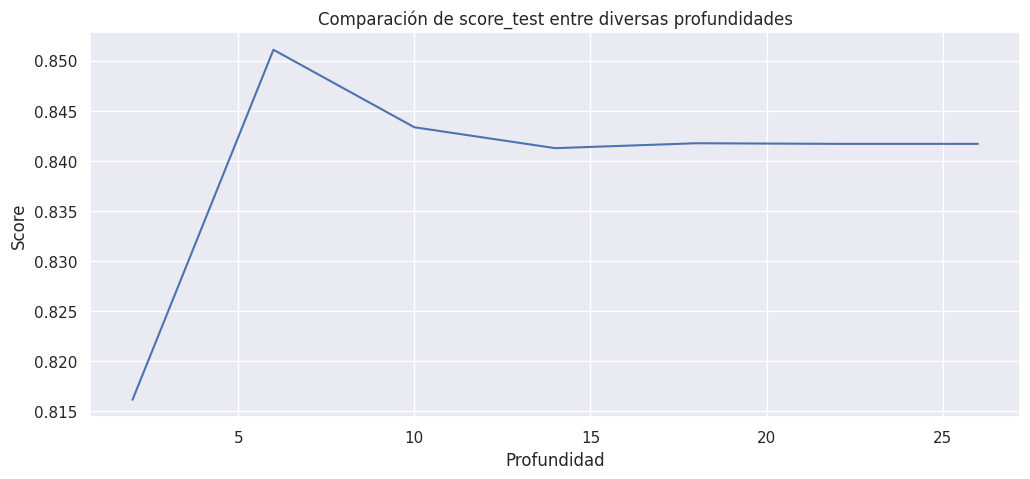

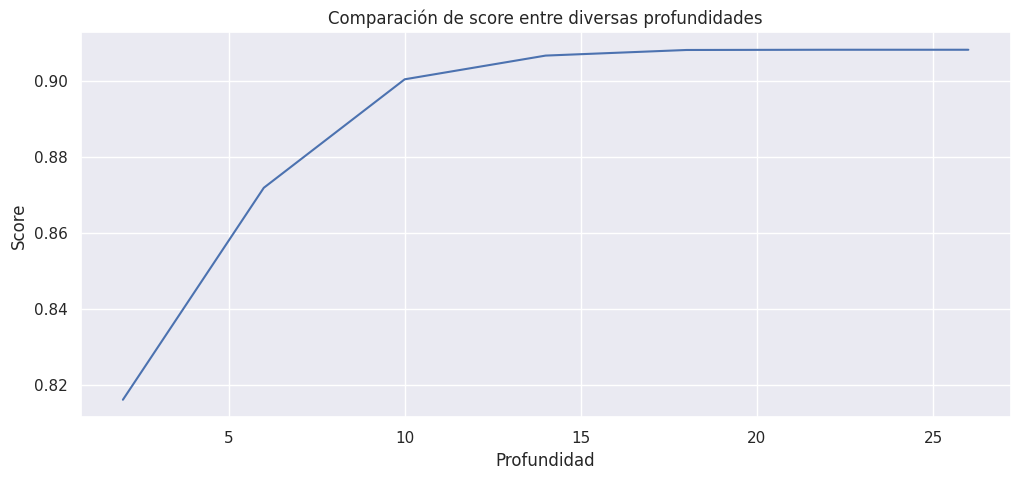

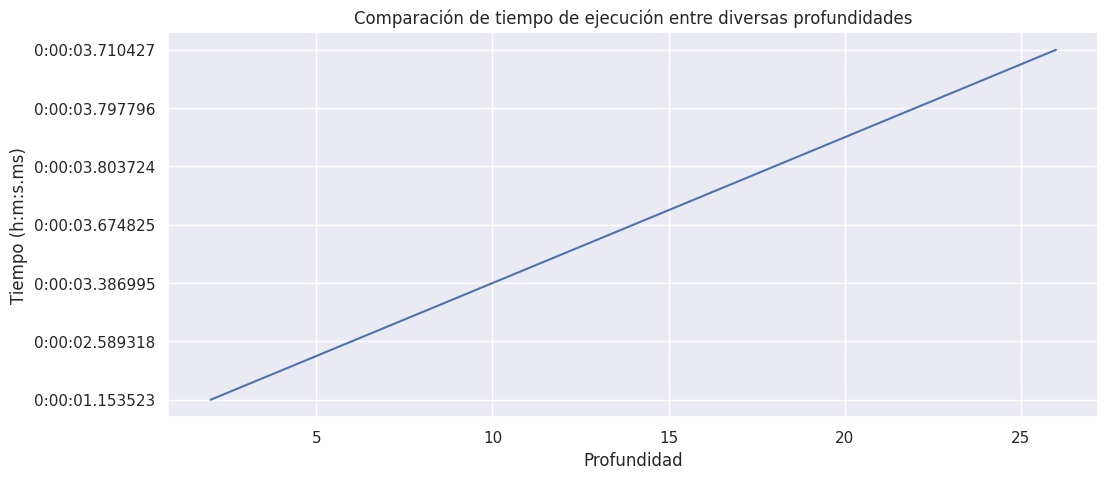

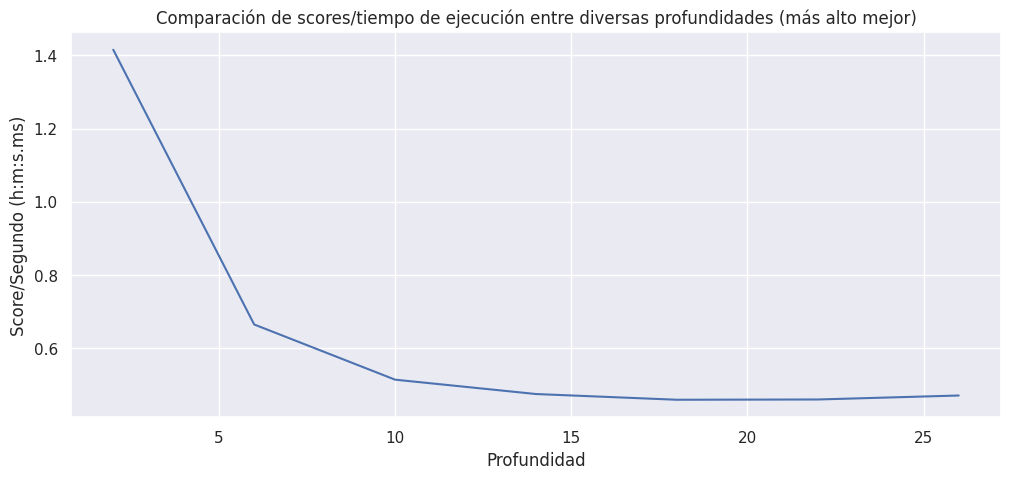

In [100]:
import matplotlib.pyplot as plt
PROFUNDIDAD_MAXIMA = 30

X,y=X2,y2
y_plot_score_test = [] 
y_plot_score = [] 
y_plot_time = []
y_plot_time_float = []

for i in range(2,PROFUNDIDAD_MAXIMA,4):
    arbol = C45Classifier(attributes, disc_atts, cont_atts, max_depth=i, criterion='classification_error', prune=False)
    arbol.fit(X2,y2)
    y_plot_score_test.append(arbol.score(X_test,y_test))
    y_plot_score.append(arbol.score(X, y))
    y_plot_time_float.append(arbol.t_exec_float)
    y_plot_time.append(arbol.t_exec)

y_score_test = np.array(y_plot_score_test)
y_score = np.array(y_plot_score)
y_time = np.array(y_plot_time)
y_time_float = np.array(y_plot_time_float)
x_criterion = np.array(range(2,PROFUNDIDAD_MAXIMA,4))

plt.title("Comparación de score_test entre diversas profundidades")
plt.ylabel('Score')
plt.xlabel('Profundidad')
plt.plot(x_criterion, y_score_test)
plt.show()

plt.title("Comparación de score entre diversas profundidades")
plt.ylabel('Score')
plt.xlabel('Profundidad')
plt.plot(x_criterion, y_score)
plt.show()

plt.title("Comparación de tiempo de ejecución entre diversas profundidades")
plt.ylabel('Tiempo (h:m:s.ms)')
plt.xlabel('Profundidad')
plt.plot(x_criterion, y_time)
plt.show()

plt.title("Comparación de scores/tiempo de ejecución entre diversas profundidades (más alto mejor)")
plt.ylabel('Score/Segundo (h:m:s.ms)')
plt.xlabel('Profundidad')
plt.plot(x_criterion, (y_score + y_score_test)/y_time_float)
plt.show()

De los resultados concluimos que el tiempo sigue una evolución lineal, mientras que el score una logarítmica. Sin embargo, al mirar el score_test podemos darnos cuenta de que alcanza la mejor puntuación con una profundidad de 6.

Si analizamos la profundidad junto a la relación entre el score y el tiempo de creación del árbol, resulta claro que conforme más profundidad menor son las ganancias en score. Sumándole también el máximo que alcanza con profundidad 6 en el test, podemos concluir que una profundidad entre 5 y 8 nos va a proporcionar un score muy bueno con un tiempo razonable.

Este comportamiento puede deberse al "overfitting", pues aprende patrones muy específicos de la base de datos con el que se entrena, que no se corresponden luego con datos del mundo real o en este caso del test. De ahí que a partir de profundidad 6 en el test el score baje.

### Comparación entre criterios
Vamos a comparar los distintos score y tiempos de ejecución entre los criterios gini, entropy y classification_error. Para los tiempos de ejecución repetimos el algoritmo N veces (configurable mediante N_REPETICIONES) y tomamos la media, pues es un valor altamente variable entre ejecuciones.

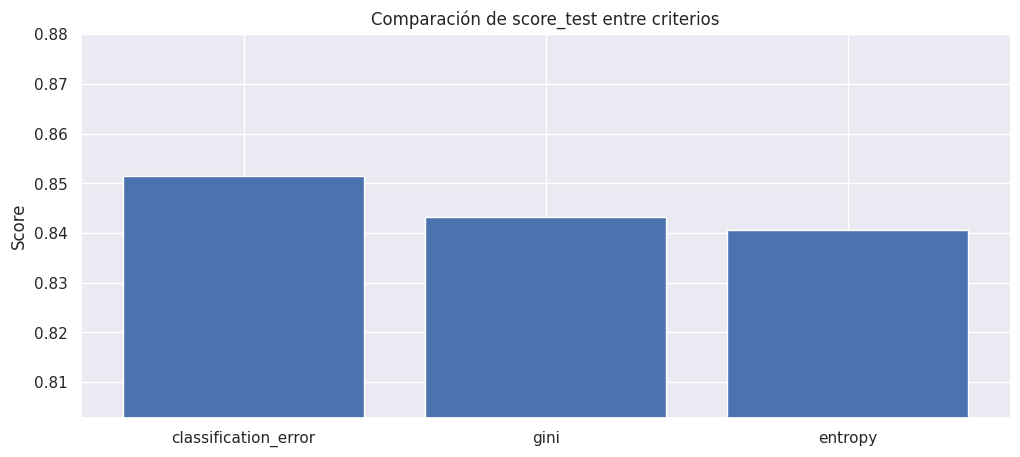

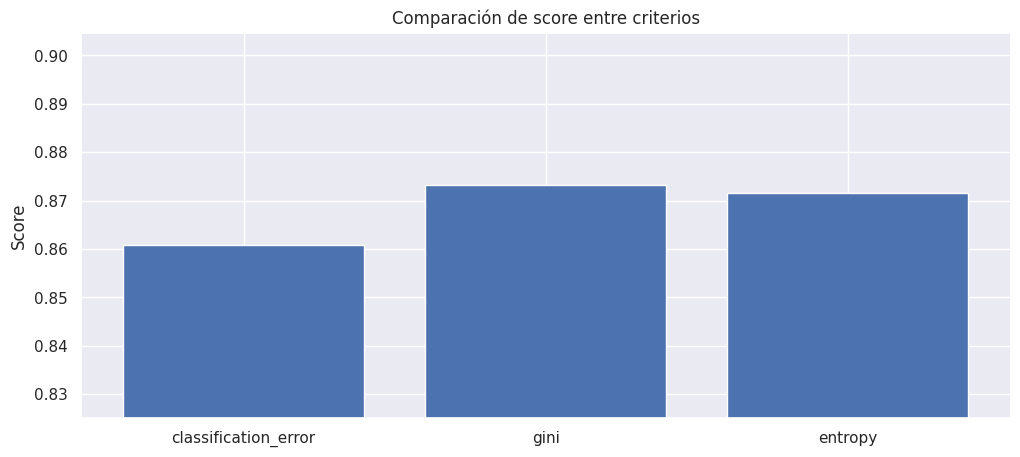

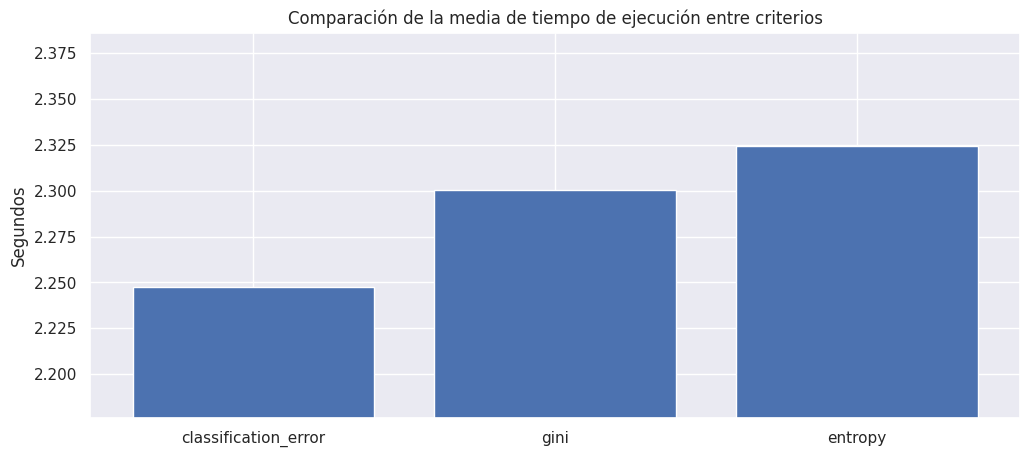

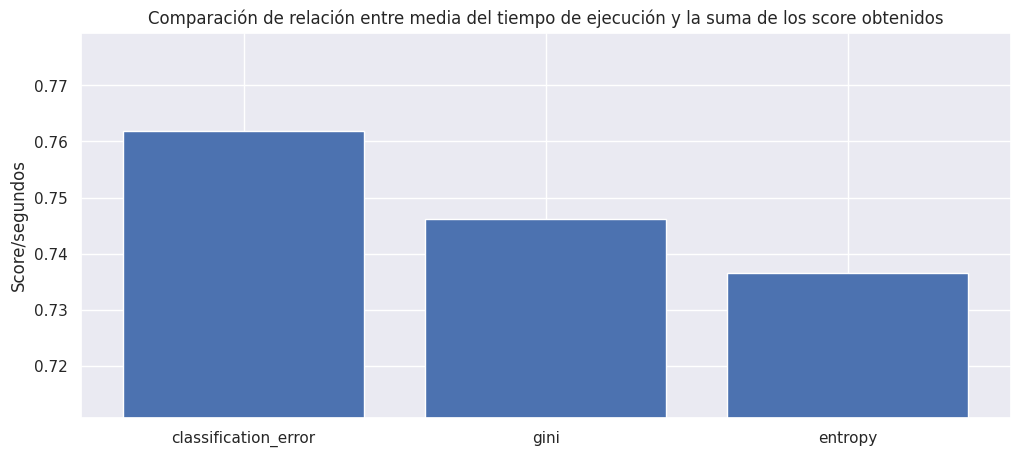

In [95]:
y_plot_score_test = [] 
y_plot_score = [] 
y_plot_time = []
criterion = []

N_REPETICIONES = 30

criterion = ['classification_error', 'gini', 'entropy']
for criterion in criterion:
    time_sum = 0
    for _ in range(N_REPETICIONES):
        arbol = C45Classifier(attributes, disc_atts, cont_atts, max_depth=5, criterion=criterion, prune=False)
        arbol.fit(X, y)
        score_test_sum = arbol.score(X_test, y_test)
        score_sum = arbol.score(X, y)
        time_sum += arbol.t_exec_float

    y_plot_score_test.append(arbol.score(X_test, y_test))
    y_plot_score.append(arbol.score(X, y))
    y_plot_time.append(time_sum/N_REPETICIONES)

y_score_test = np.array(y_plot_score_test)
y_score = np.array(y_plot_score)
y_time = np.array(y_plot_time)
y_score_time = (np.array(y_plot_score_test) + np.array(y_plot_score)) / np.array(y_plot_time)
x_criterion = np.array(['classification_error', 'gini', 'entropy'])

limite_inferior = np.mean(y_score_test)-(np.mean(y_score_test)/20)
limite_superior = np.mean(y_score_test)+(np.mean(y_score_test)/24)
plt.ylim(limite_inferior, limite_superior)
plt.title("Comparación de score_test entre criterios")
plt.ylabel('Score')
plt.bar(x_criterion, y_score_test)
plt.show()

limite_inferior = np.mean(y_score)-(np.mean(y_score)/20)
limite_superior = np.mean(y_score)+(np.mean(y_score)/24)
plt.ylim(limite_inferior, limite_superior)
plt.title("Comparación de score entre criterios")
plt.ylabel('Score')
plt.bar(x_criterion, y_score)
plt.show()

limite_inferior = np.mean(y_time)-(np.mean(y_time)/20)
limite_superior = np.mean(y_time)+(np.mean(y_time)/24)
plt.ylim(limite_inferior, limite_superior)
plt.bar(x_criterion, y_time)
plt.title("Comparación de la media de tiempo de ejecución entre criterios")
plt.ylabel('Segundos')
plt.show()

limite_inferior = np.mean(y_score_time)-(np.mean(y_score_time)/20)
limite_superior = np.mean(y_score_time)+(np.mean(y_score_time)/24)
plt.ylim(limite_inferior, limite_superior)
plt.bar(x_criterion, y_score_time)
plt.title("Comparación de relación entre media del tiempo de ejecución y la suma de los score obtenidos")
plt.ylabel('Score/segundos')
plt.show()

Podemos concluir que classification_error es el criterio más eficiente, pues aunque sea el que peor score tiene, en el caso del test consigue superar a los otros dos mientras que también tarde considerablemente menos que entropy y gini. Entropy es con diferencia el peor, pues no consigue superar a gini respecto al score y además tarda más en entrenarse.

Entropy tarda tanto debido al calculo de logaritmos, que necesita más coste computacional que el resto de criterios. En el caso de classification_error este calculo es simplemente una resta y un conteo, por lo que es el más simple y de eso que también sea el que menos tarda. Respecto al score, hemos podido comprobar que el indice de gini es el más preciso, al menos en la base de datos proporcionada.

### Tiempo de ejecuccion de la poda
Con esta parte del código, queremos comprobar cuánto afecta la boda al tiempo de ejecución, Sin embargo, al tratar con bases de datos, no tan grandes, existen variaciones considerables, dependiendo del tiempo de procesador, el cual el proceso está

El tiempo sin poda es 0:00:04.055306 y el tiempo con poda es 0:00:04.185963


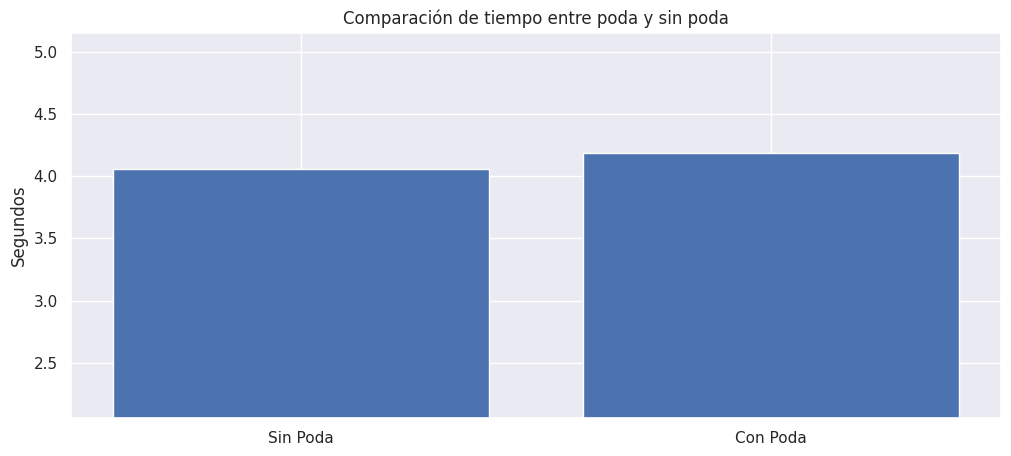

In [77]:
conPoda = 0
sinPoda = 0
inf = [0] * 2 

arbol = C45Classifier(attributes, disc_atts, cont_atts, max_depth=10, criterion=criterion, prune=True)
arbol.fit(X, y)
conPoda = arbol.t_exec_float + arbol.t_prune_float
inf[0] = arbol.t_exec

arbol = C45Classifier(attributes, disc_atts, cont_atts, max_depth=10, criterion=criterion, prune=False)
arbol.fit(X, y)
sinPoda = arbol.t_exec_float
inf[1] = arbol.t_exec

y_ploting = np.array([sinPoda,conPoda])
x_ploting = np.array(["Sin Poda", "Con Poda"])

limite_inferior = np.mean(y_ploting)-(np.mean(y_ploting)/2)
limite_superior = np.mean(y_ploting)+(np.mean(y_ploting)/4)

print(f"El tiempo sin poda es {inf[1]} y el tiempo con poda es {inf[0]}")
plt.title("Comparación de tiempo entre poda y sin poda")
plt.ylabel('Segundos')
plt.ylim(limite_inferior, limite_superior)
plt.bar(x_ploting, y_ploting)
plt.show()


### Limite de particion en cuartiles
Con este código, queremos implementar unas gráficas para poder observar cómo se comporta la probabilidad de entreno y del test, al igual que el tiempo de ejecución en función del número de parámetros necesarios para considerar que es lo suficientemente grandes, como para partirlos en cuartiles

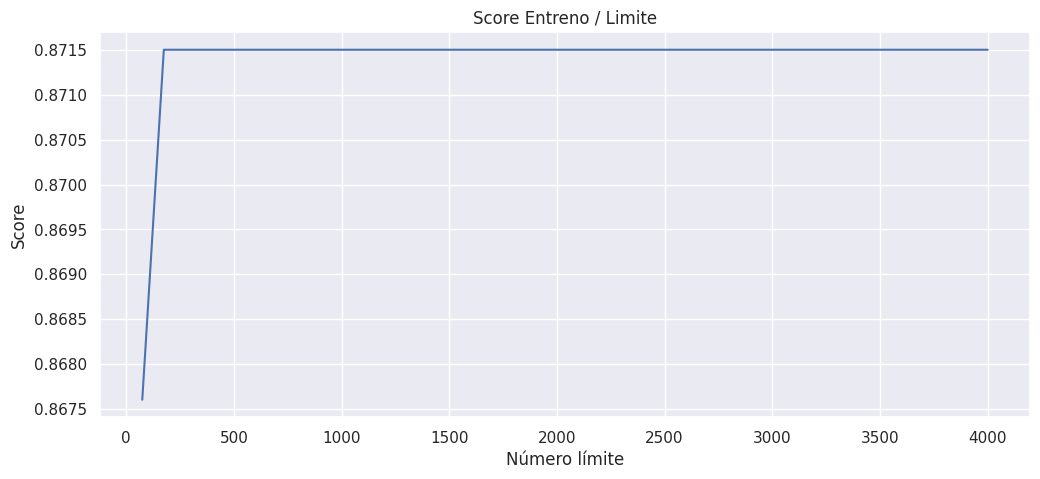

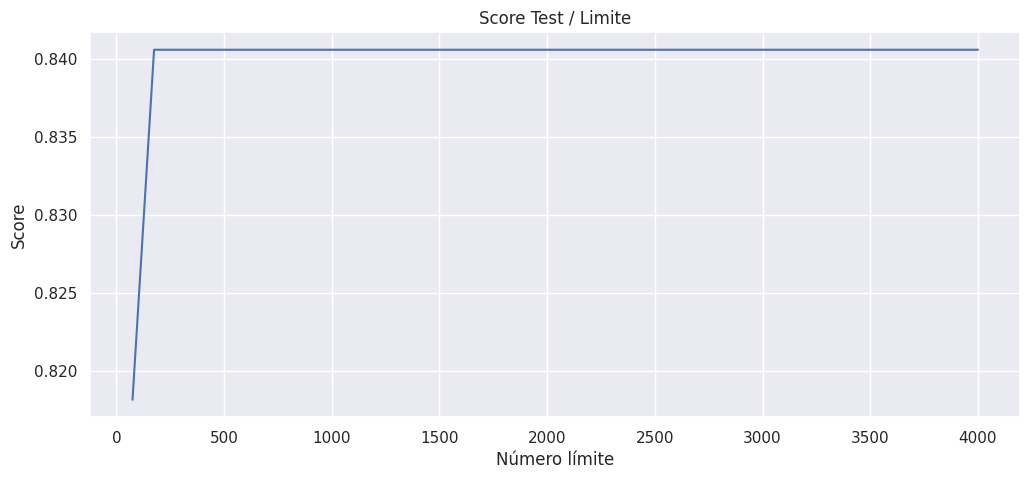

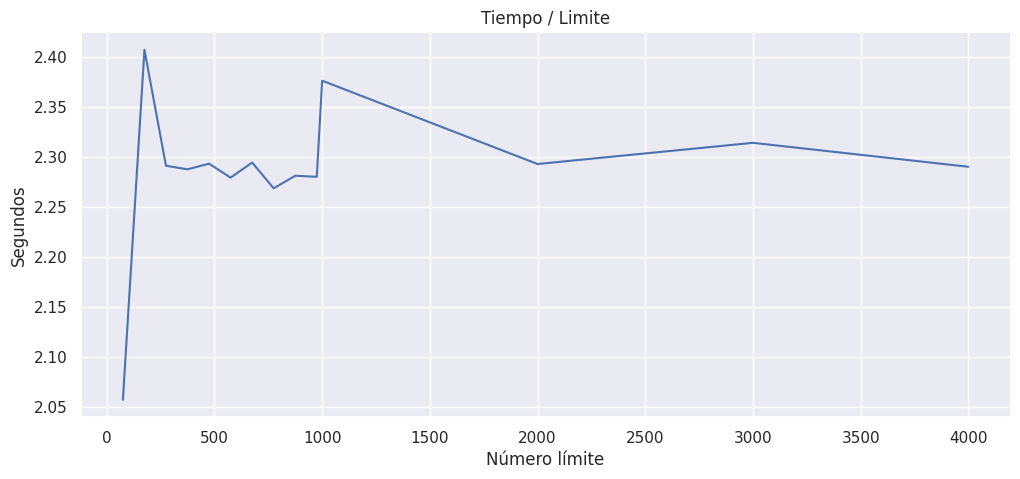

Score test sin límite:  0.8393833302622689
Score entreno sin límite:  0.8720555265501674
Tiempo sin límite:  0:00:27.495451


In [103]:
limites = list(range(75,1000,100)) + list(range(1000,5000,1000))
score_Entreno = []
score_Test = []
tiempos = []

for limit in limites:
    arbol = C45Classifier(attributes, disc_atts, cont_atts, max_depth=5, criterion=criterion, prune=False)
    arbol.LIMIT = limit
    arbol.fit(X, y)
    score_Entreno.append(arbol.score(X,y))
    score_Test.append(arbol.score(X_test,y_test))
    tiempos.append(arbol.t_exec_float)

ejeY_entrenoLimite = np.array(score_Entreno)
ejeY_testLimite = np.array(score_Test)
ejeY_tiempoLimite = np.array(tiempos)

ejeX = np.array(limites)

arbol = C45Classifier(attributes, disc_atts, cont_atts, max_depth=5, criterion=criterion, prune=False)
arbol.LIMIT = 99999999 # Sin límite
arbol.fit(X, y)
sc_entreno_sl = arbol.score(X, y)
sc_test_sl = arbol.score(X_test, y_test)
tiempo_sl = arbol.t_exec

plt.title("Score Entreno / Limite")
plt.ylabel('Score')
plt.xlabel('Número límite')
plt.plot(ejeX, ejeY_entrenoLimite)
plt.show()

plt.title("Score Test / Limite")
plt.ylabel('Score')
plt.xlabel('Número límite')
plt.plot(ejeX, ejeY_testLimite)
plt.show()

plt.title("Tiempo / Limite")
plt.xlabel('Número límite')
plt.ylabel('Segundos')
plt.plot(ejeX, ejeY_tiempoLimite)
plt.show()

print("Score test sin límite: ", sc_test_sl)
print("Score entreno sin límite: ", sc_entreno_sl)
print("Tiempo sin límite: ",tiempo_sl)

